In [136]:
import numpy as np
from umap import UMAP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics         import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import AdaBoostClassifier

## Importation des vecteurs encodés

In [158]:
# Chemin vers le fichier .npy contenant les embeddings de GigaSSL
path_to_embeds = 'features_MESO_AI_moco_mlp.npy'
# Chemin vers le dossier contenant les annotations des lames
path_to_meta = 'INSA_project_slides_anonym.xlsx'

dico_embeddings = np.load(path_to_embeds, allow_pickle=True).item()
df_embeddings = pd.DataFrame(dico_embeddings).T
df_embeddings["ID"] = df_embeddings.index
df_embeddings = df_embeddings.reset_index(drop=True)
meta=pd.read_excel(path_to_meta, sheet_name="Feuil1", usecols="A,B")
meta['ID'] = meta['NOUVEAU_NOM'].str[:-4]
meta = meta.drop(['NOUVEAU_NOM'], axis = 1)
data = pd.merge(df_embeddings,meta,left_on="ID",right_on="ID")
data = data.dropna()
X = data.iloc[:,0:512]
y = data["BAP1"]

In [159]:
# Pour avoir autant des deux classes:
data_no_bap1=data[data["BAP1"]==0][:181]
data_bap1=data[data["BAP1"]==4]
data_eq=pd.concat([data_bap1,data_no_bap1])
X = data_eq.iloc[:,0:512]
y = data_eq["BAP1"]

## Visualisation des vecteurs

In [11]:
reducer = UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
X_red=reducer.fit_transform(X)
X_red_df=pd.DataFrame(X_red, index = data.index)
data_red = pd.concat([data.iloc[:,512:514], X_red_df], axis = 1)

c:\Users\lasse\anaconda3\envs\conch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


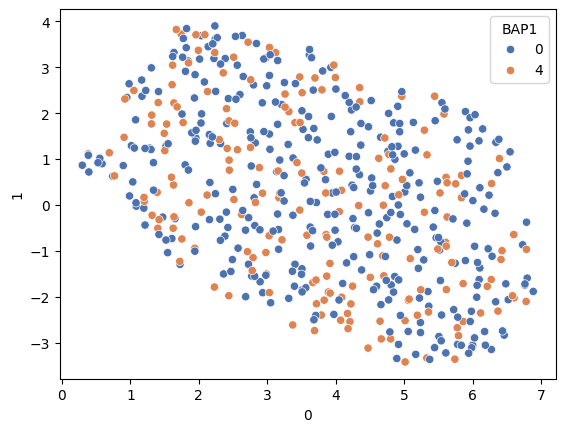

In [17]:
# Visualisation en fonction de BAP1 exprimé ou non 

sns.scatterplot(
   x=0,
   y=1,
   data=data_red,
   hue="BAP1",
   palette = "deep"
)

plt.show()

## Classification des lames

In [160]:
# Separation des jeux de test et d'entrainement
y=y.replace({4 : 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, stratify=y)

[0.46666667 0.33333333 0.23333333]
Accuracy avec validation croisée LR: 0.344 +- 0.192
Accuracy sur le jeu de test LR: 0.4722222222222222


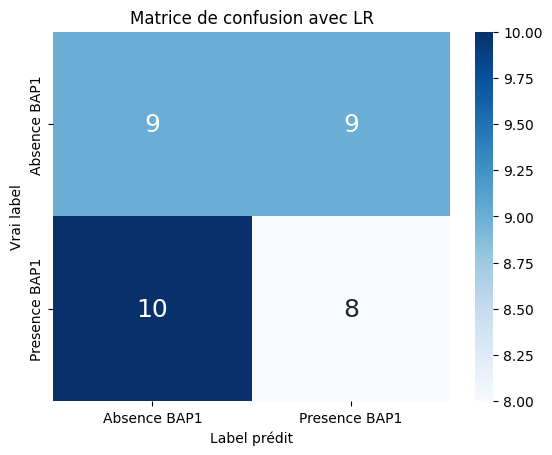

In [154]:
# Logistic regression
lr_clf = LogisticRegression(C=100, penalty='l2', class_weight='balanced',solver="saga",max_iter=1000)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(lr_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée LR:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
print(f"Accuracy sur le jeu de test LR: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Presence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec LR")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

[0.45454545 0.46280992 0.54166667]
Accuracy avec validation croisée SVC: 0.486 +- 0.078
Accuracy sur le jeu de test SVC: 0.4689655172413793


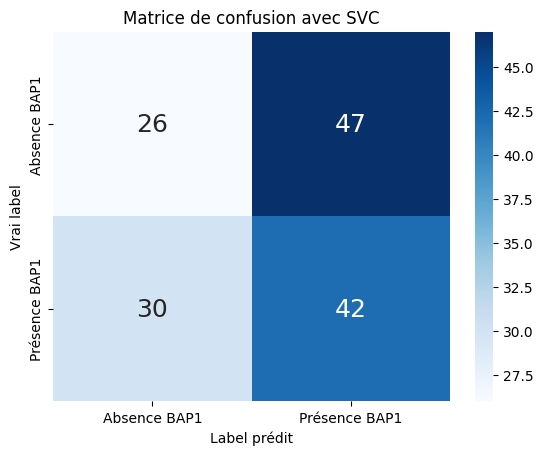

In [8]:
# Support Vector Classifier
svc_clf = SVC(kernel='rbf', C=1000)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(svc_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée SVC:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(f"Accuracy sur le jeu de test SVC: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec SVC")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

[0.53719008 0.57024793 0.525     ]
Accuracy avec validation croisée KNN: 0.544 +- 0.038
Accuracy sur le jeu de test KNN: 0.46206896551724136


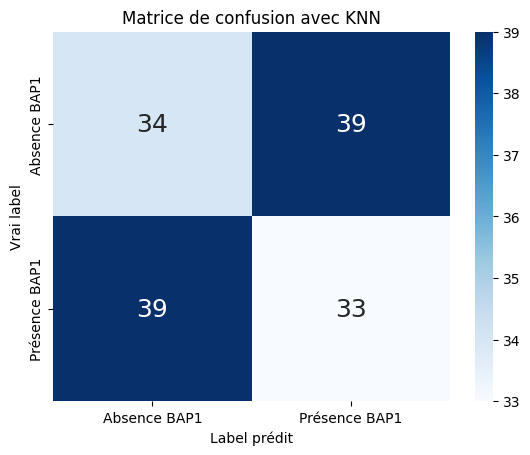

In [10]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(knn_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée KNN:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print(f"Accuracy sur le jeu de test KNN: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec KNN")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

[0.53719008 0.53719008 0.525     ]
Accuracy avec validation croisée KNN: 0.533 +- 0.012
Accuracy sur le jeu de test KNN: 0.4482758620689655


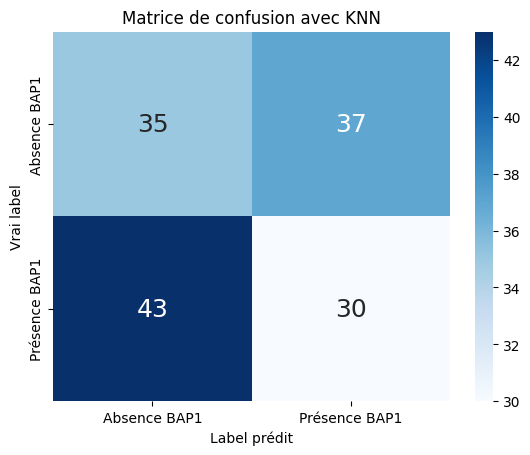

In [161]:
# AdaBoost

ada_clf = AdaBoostClassifier(
    estimator=LogisticRegression(C=10, penalty='l2', class_weight='balanced',solver="saga",max_iter=1000),
    n_estimators=10,
    learning_rate=0.1,
    algorithm='SAMME',
    random_state=None
)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(ada_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée KNN:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(f"Accuracy sur le jeu de test KNN: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec KNN")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

## Avec TCGA

In [119]:
# Importation des encodages de TCGA

# Chemin vers le fichier .npy contenant les embeddings de GigaSSL
path_to_embeds = 'TCGA-gigassl_moco.npy'
# path_to_embeds = 'TCGA-gigassl_ctranspath.npy'

dico_embeddings = np.load(path_to_embeds, allow_pickle=True).item()
df_embeddings = pd.DataFrame.from_dict(dico_embeddings,orient='index')
df_embeddings["ID"] = df_embeddings.index
df_embeddings= df_embeddings.reset_index(drop=True)
df_embeddings['Sample'] = df_embeddings['ID'].str[:15]

In [120]:
# Ajout du statut de BAP1 et du type

# Chemin vers le dossier contenant les annotations des lames sur BAP1
path_to_meta_BAP1 = "TCGA_BAP1_metadata.xlsx"
# Chemin vers le dossier contenant les annotations des lames sur le type
path_to_meta_type = "TCGA_Type_metadata.xlsx"

meta_BAP1 = pd.read_excel(path_to_meta_BAP1,sheet_name="2A_BAP1 status",usecols="A,B")
meta_type = pd.read_excel(path_to_meta_type,sheet_name="TableS2",usecols="A,R")
data = pd.merge(df_embeddings,meta_type, on="Sample", how="inner")
data = pd.merge(data,meta_BAP1,left_on="Sample",right_on="TCGA_barcode")

In [121]:
# Correction des données

# no_inactivation et % cellules tumorales <50%
data = data[data['Sample']!='TCGA-TS-A7P8-01A']
data = data[data['Sample']!='TCGA-TS-A7P6-01A']
data = data[data['Sample']!='TCGA-SC-A6LR-01A']

# Cas ambigu présence d'un gain de nombre de copies, mais pas de niveau d'expression élevé 
data = data[data['Sample']!='TCGA-YS-AA4M-01A']

# possibly_inactivated mais niveau d'expression elevé
data.loc[data['Sample'] == 'TCGA-LK-A4NZ-01A', 'BAP1_status'] = 'inactivated'

In [122]:
# Pour avoir autant des deux classes:
data_no_bap1=data[data["BAP1_status"]=="inactivated"][:29]
data_bap1=data[data["BAP1_status"]=="no_inactivation"]
data_eq=pd.concat([data_bap1,data_no_bap1])
X = data_eq.iloc[:,0:512]
y = data_eq["BAP1_status"]
type = data_eq["Type.Review"]

In [102]:
data_crosstab = pd.crosstab(data_eq['Type.Review'], 
                            data_eq['BAP1_status'],  
                               margins = True) 
print(data_crosstab) 

BAP1_status  inactivated  no_inactivation  All
Type.Review                                   
MMB                    2                7    9
MME                   27               20   47
MMS                    0                2    2
All                   29               29   58


In [103]:
# Création des jeux de test et d'entrainement
y=y.replace({ 'no_inactivation' : 1, 'inactivated':0})
X_train, X_test, y_train, y_test, type_train, type_test = train_test_split(X, y, type, train_size=0.7, shuffle=True, stratify=y)

C:\Users\lasse\AppData\Local\Temp\ipykernel_15088\1985451042.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=y.replace({ 'no_inactivation' : 1, 'inactivated':0})


[0.75       0.78947368 0.63157895]
Accuracy avec validation croisée LR: 0.724 +- 0.134
Accuracy sur le jeu de test LR: 0.8333333333333334


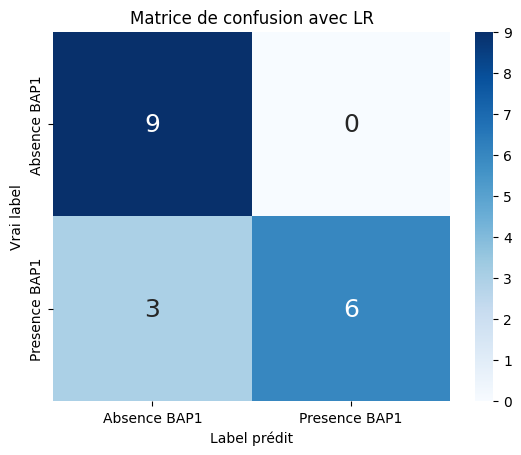

Prediction   0  1  All
Type                  
MMB          0  2    2
MME         12  4   16
All         12  6   18


In [91]:
# Logistic regression
lr_clf = LogisticRegression(C=100, penalty='l2', class_weight='balanced',solver="saga",max_iter=1000)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(lr_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée LR:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
print(f"Accuracy sur le jeu de test LR: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Presence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec LR")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

# Test si biaisé par rapport au type:
d = {"Prediction": y_pred, "Realite": y_test, "Type": type_test}
results = pd.DataFrame(d)
data_crosstab = pd.crosstab(results['Type'], 
                            results['Prediction'],  
                               margins = True) 
print(data_crosstab) 

[0.8        0.73684211 0.63157895]
Accuracy avec validation croisée SVC: 0.723 +- 0.138
Accuracy sur le jeu de test SVC: 0.6111111111111112


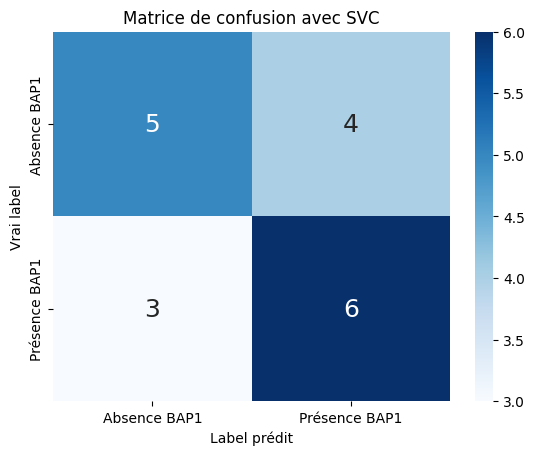

Prediction  0   1  All
Type                  
MMB         1   2    3
MME         7   8   15
All         8  10   18


In [104]:
# Support Vector Classifier
svc_clf = SVC(kernel='rbf', C=1000)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(svc_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée SVC:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(f"Accuracy sur le jeu de test SVC: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec SVC")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

# Test si biaisé par rapport au type:
d = {"Prediction": y_pred, "Realite": y_test, "Type": type_test}
results = pd.DataFrame(d)
data_crosstab = pd.crosstab(results['Type'], 
                            results['Prediction'],  
                               margins = True) 
print(data_crosstab) 

[0.75       0.47368421 0.52631579]
Accuracy avec validation croisée KNN: 0.583 +- 0.24
Accuracy sur le jeu de test KNN: 0.5555555555555556


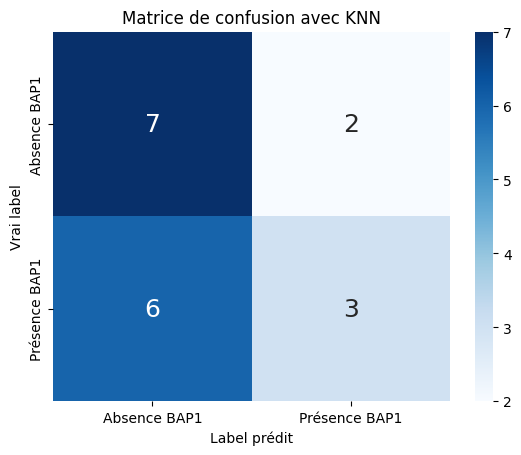

In [106]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(knn_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée KNN:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print(f"Accuracy sur le jeu de test KNN: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec KNN")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()